<style>
    @media print{
        body {
            position:relative !important;
        }
        .celltag_new_page {
            page-break-before: always !important;
        }
    }
</style>
# COMPSCI 371D Homework 1

Olivia Fan, Frankie Willard, Sam Carpenter

### Problem 0 (3 points)

## Part 1: Sets and Functions 

### Problem 1.1 (Exam Style)

$$
\begin{array}{|c|c|c|c|c|c|c|c|}
	\hline
	\mbox{Domain} & \mbox{Codomain} & \mbox{Map} & \mbox{Function?} & \mbox{Injection?} & \mbox{Surjection?} & \mbox{Bijection?}
	& \mbox{None of these} \\\hline
	\{1, 2\} & \{a, b\} & \{(1, a), (1, b)\} & & & & & yes \\\hline
	\{1, 2\} & \{a, b\} & \{(1, a), (2, a)\} & yes & & & & \\\hline
	\{1, 2\} & \{a, b\} & \{(1, b), (2, a)\} & yes & yes & yes & yes & \\\hline
	\{1, 2\} & \{a, b, c\} & \{(2, a), (1, c)\} & yes & yes & & & \\\hline
	\{1, 2\} & \{b\} & \{(1, b), (2, b)\} & yes & & yes & & \\\hline
\end{array}
$$

### Problem 1.2 (Exam Style)

Every individual value in A has $2^b$ distinct possibilities it can map to; for each element in $B$, it can either map to the element or not. Since there are $a$ elements present, and the empty map should not be counted, there are $2^{ab}-1$ possible maps.

$$ n(a,b) = {ab \choose 1 }+  {ab \choose 2} +  {ab \choose 3} + ...+  {ab \choose ab-1} + {ab \choose ab} \\
= 2^{ab}-1 $$
Numerical examples:
$$ n(3,3) = 2^9 -1 = 511 \\
n(2,4) = 2^8 -1 = 255 \\
n(5,3) = 2^15 - 1 = 32,767 $$

### Problem 1.3 (Exam Style)

Every element in $A$ must map to an element in $B$ for it to be a function; it can only map to one. Therefore, each element in $A$ has $b$ possibilities to map to. This means that there are $b^a$ distinct possibilities for functions.

$$ n(a,b) = b^a$$
Numerical examples:
$$n(3,3) = 3^3 = 27 \\
n(2,4) = 4^2 = 16 \\
n(5,3) = 3^5 = 243 $$

### Problem 1.4 (Exam Style)

$$ n(a,b) = \begin{cases} a! &\mbox{if } a = b \\ 
0 & \mbox{if } a \neq b \end{cases}$$
Numerical examples:
$$ n(4,4) = 24 \\
n(2,4) = 0 \\
n(5,3) = 0
$$

### Problem 1.5 (Exam Style)

There are ${M \choose N}$ possible ways to pick email messages. For a given selection of said messages, each can be labeled either True or False, so there are $2^N$ ways for an individual selection to exist. Overall, there are $2^N * {M \choose N}$ distinct training sets.
<br>The number of distinct training sets of N samples that could be conceivably constructed is
$$ {M \choose N} \times 2^N $$
For N = 5 and M = 8, the number of distinct training sets of N samples that could be conceivably constructed is
$$ {8 \choose 5} \times 2^5 = 1792 $$

## Part 2: Fitting Banded Linear Transformations 

### Problem 2.1

In [1]:
from urllib.request import urlretrieve
from os import path as osp


def retrieve(file_name, semester='fall21', course='371d', homework=1):
    if osp.exists(file_name):
        print('Using previously downloaded file {}'.format(file_name))
    else:
        fmt = 'https://www2.cs.duke.edu/courses/{}/compsci{}/homework/{}/{}'
        url = fmt.format(semester, course, homework, file_name)
        urlretrieve(url, file_name)
        print('Downloaded file {}'.format(file_name))


In [2]:
import pickle


def read_data(file_name):
    retrieve(file_name)
    with open(file_name, 'rb') as file:
        d = pickle.load(file)
    return d

In [3]:
data = {data_set: read_data('{}.pkl'.format(data_set))
        for data_set in ('training', 'test')}

Using previously downloaded file training.pkl
Using previously downloaded file test.pkl


In [4]:
x_tr, y_tr = data['training']['x'], data['training']['y']

In [5]:
import numpy as np


def solve_system(u, v):
    return np.linalg.lstsq(u, v, rcond=None)[0]

In [6]:
h = solve_system(x_tr, y_tr)

In [7]:
def residual(h, x, y):
    diff = np.dot(x, h) - y
    r = np.linalg.norm(diff) / np.sqrt(x.size)
    return r

In [8]:
def diagonal_indicator(d, bandwidth):
    ind = np.zeros((d, d))
    for k in range(-bandwidth, bandwidth + 1):
        length = d - np.abs(k)
        ones = np.ones(length)
        ind += np.diag(ones, k=k)
    return ind.astype(bool)

In [9]:
def un_flatten_solution(h_flat, d, bandwidth):
    indicator = diagonal_indicator(d, bandwidth)
    h = np.zeros(d * d)
    h[indicator.ravel()] = h_flat
    h = np.reshape(h, (d, d))
    return h

In [10]:
# helper function that takes the two matrices X and Y 
# and a bandwidth and constructs A and y from it
def flatten_system(x, y, bandwidth):
    # X is a Nxd array
    d = x.shape[1]
    #You know how to make Y
    y_flat = y.flatten()
    # Make the full A using the Kronecker product.
    A = np.kron(x, np.eye(d))
    #Find the diagonal indicator of H and flatten it.
    indicator = diagonal_indicator(d, bandwidth)
    indicator_flat = indicator.flatten()
    # Retain only the columns of A flagged for retention by the flattened indicator.
    A_retain = A[:,indicator_flat == True]
    return [A_retain, y_flat]

In [11]:
def fit_banded_matrix(x, y, bandwidth):
    # X is a Nxd array
    d = x.shape[1]
    rearranged_system = flatten_system(x, y, bandwidth)
    #rearranged_system[0] is A, out[1] is y_flat
    h_flat = solve_system(rearranged_system[0], rearranged_system[1])
    h = un_flatten_solution(h_flat, d, bandwidth)
    return h

In [12]:
# Compute the best fit H for bandwidth in 0, ..., 10
bandwidth_interval = [i for i in range (0,11)]
# Compute the residual and append it to a list
residuals = []
for bandwidth in bandwidth_interval:
    optimal_h = fit_banded_matrix(x_tr, y_tr, bandwidth)
    residuals.append(residual(optimal_h, x_tr, y_tr))

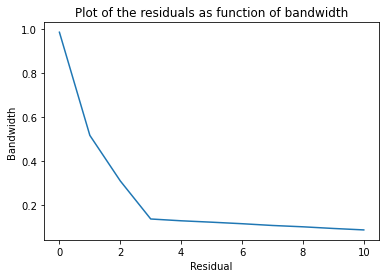

In [13]:
# Plotting the residuals as a function of bandwidth
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(bandwidth_interval,residuals)
plt.xlabel('Residual')
plt.ylabel('Bandwidth')
plt.title("Plot of the residuals as function of bandwidth")
plt.show()

### Problem 2.2 (Exam Style)

Let's assume that the graph is not monotonically decreasing.
Rather, we have a predictor $H_{b}$ in our equation that minimizes the training error for bandwidth b, which is greater than $H_{b-1}$, our previous minimum training error for bandwidth b-1.

As we increase bandwidth, we are increasing the dimensionality of our predictor such that we have all of the same features as the previous dimension d -1, but add features/new polynomial degrees that extend to the new dimension d. Thus, there are more ways in which we can fit our function with various coefficients. At the absolute worst performance, it will set the newly-usable coefficients to 0, resulting in the same matrix as the previous iteration. The ability to set values in our H matrix to 0 means that the hypothesis space for the previous dimension d-1 is contained within the hypothesis space for the new dimension (bandwidth). In expanding the size of the hypothesis space, we can never increase our training error, and rather only stay constants or decrease towards limit 0 (as degree p approaches data points n) when a new function is introduced with a lower training error.

Thus, $H_{b-1}$ is in our hypothesis space and $H_{b-1}$ < $H_{b}$. H represents the true minimum for our training error such that $H_{b}$ can not be less than $H_{b-1}$, but rather should be equal to $H_{b-1}$ as $H_{b-1}$ is in the hypothesis space. With $H_{b-1}$, the function will not increase, but rather stay the same. Thus, by contradiction, training error must monotonically decrease, as the hypothesis space for bandwidth b will always include the hypothesis spaces for bandwidth=1...b-1, and thus can not have a worse predictor that represents the true optimal matrix H for minimizing training error.

The graph above therefore must be motonically decreasing.

## Part 3: Learning Banded Linear Transformations 

### Problem 3.1

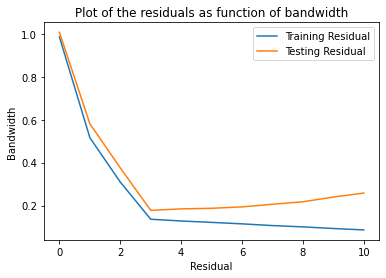

In [16]:
x_ts, y_ts = data['test']['x'], data['test']['y']

residuals_train = []
residuals_test = []

for bandwidth in bandwidth_interval:
    optimal_h = fit_banded_matrix(x_tr, y_tr, bandwidth)
    residuals_train.append(residual(optimal_h, x_tr, y_tr))
    residuals_test.append(residual(optimal_h, x_ts, y_ts))
    
#plotting the curves
fig, ax = plt.subplots()
ax.plot(bandwidth_interval, residuals_train, label = "Training Residual")
ax.plot(bandwidth_interval, residuals_test,  label = "Testing Residual" )
plt.xlabel('Residual')
plt.ylabel('Bandwidth')
plt.title("Plot of the residuals as function of bandwidth")
plt.legend()

### Problem 3.2 (Exam Style)

A bandwidth of 3 was likely used to generate the data because it is the optimal bandwidth for the testing data. The residual for the testing data does not monotonically decrease, because as the bandwidth increases, H overfits to the training data and becomes less accurate on the testing data as it models less and less of the actually significant distribution. There is a cusp on the graph when bandwidth is equal to 3. The residuals decrease until bandwidth increases to 3, and decreases after it goes beyond 3, which illustrates that 3 is the optimal bandwidth since we want to avoid overfitting with an overly large hypothesis space (modeling random fluctuations) and underfitting with an overly small one (modeling the deterministic part poorly).

In increasing bandwidth, we increase our hypothesis space to includes predictors that can model more and more complex relationships. However, in allowing for more predictors to be considered, the optimal predictor for testing data may become less likely to selected. Predictors that minimize training error to prevail, such that increasing dimensionality incentivizes predictors to account for both the signal and noise (minimize bias). However, these large polynomials have great variance, as adding just one new data point will often create a large residual and would require an entirely different predictor to model it. Thus, when applied to new data points in the test set, we find that these complex functions may not generalize well, and thus cause test performance to worsen. Meanwhile, a less complex polynomial that may be in the hypothesis space with bandwidth 3, may only capture the signal of the training data and perform well (but not too perfect) while allowing for some, small residuals/bias in the training data, but its simpler nature allows for a lower variance such that it generalizes well to the testing data